In [51]:
import pandas as pd

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

##### import data

In [53]:
repo=pd.read_csv('data/CommitData/C_facebook_react.csv', sep=",")

In [54]:
repo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16123 entries, 0 to 16122
Data columns (total 13 columns):
 #   Column                                                                              Non-Null Count  Dtype 
---  ------                                                                              --------------  ----- 
 0   url                                                                                 16123 non-null  object
 1   sha                                                                                 16123 non-null  object
 2   owner                                                                               16123 non-null  object
 3   repo                                                                                16123 non-null  object
 4   author                                                                              14258 non-null  object
 5   date                                                                                16123 non-null  ob

### Data Cleaning


In [55]:
repo = repo.rename(columns={'fileTuples<fileName. status. additions. deletions. changes. raw_url. contents_url>': 'fileTuple'})
repo['net_code_change'] = repo['totalAdditions'] - repo['totalDeletions']
repo = repo[['url', 'repo', 'author', 'date','totalAdditions',
       'totalDeletions','net_code_change', 'message', 'numFiles', 'numComments',
       'fileTuple']]

repo = repo.sort_values(by='date', ascending=True)

In [56]:
repo.sort_values(by='date', inplace=True)

In [57]:
import numpy as np
repo['date'] = pd.to_datetime(repo['date'])

# Sort the data by date to ensure correct calculations
repo.sort_values(by='date', inplace=True)

# Calculate commit frequency per month
repo['month'] = repo['date'].dt.to_period('M')
monthly_commits = repo.groupby('month').size().rename('monthly_commits')
# Calculate the number of unique authors per month
monthly_unique_authors = repo.groupby('month')['author'].nunique().rename('monthly_unique_authors')

monthly_additions = repo.groupby('month')['totalAdditions'].sum().rename('monthly_additions')
monthly_deletions = repo.groupby('month')['totalDeletions'].sum().rename('monthly_deletions')

repo['code_churn'] = repo['totalAdditions'] + repo['totalDeletions']

repo = repo.set_index('month').join([monthly_commits, monthly_unique_authors, monthly_additions, monthly_deletions])

repo.reset_index(inplace=True)

repo['time_between_commits'] = repo['date'].diff().dt.total_seconds().div(3600).fillna(0)

C:\Users\ethan\AppData\Local\Temp\ipykernel_11932\2028832655.py:10: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  repo['month'] = repo['date'].dt.to_period('M')


In [58]:
repo.head(1)

,month,url,repo,author,date,totalAdditions,totalDeletions,net_code_change,message,numFiles,numComments,fileTuple,code_churn,monthly_commits,monthly_unique_authors,monthly_additions,monthly_deletions,time_between_commits
0,2013-05,https://api.github.com/repos/facebook/react/co...,react,benjamn,2013-05-28 17:04:45+00:00,2,2,0,Fix some silly uses of Function.prototype.bind...,1,0,"[('vendor/jasmine/jasmine-support.js', 'modifi...",4,84,8,44823,827,0.0


In [59]:
repo.isnull().sum()

month                        0
url                          0
repo                         0
author                    1865
date                         0
totalAdditions               0
totalDeletions               0
net_code_change              0
message                      0
numFiles                     0
numComments                  0
fileTuple                    0
code_churn                   0
monthly_commits              0
monthly_unique_authors       0
monthly_additions            0
monthly_deletions            0
time_between_commits         0
dtype: int64

In [60]:
repo.to_csv('Data/ml_data/Ali_baba_commit_pb.csv', index=False)

#### AR1 Times Series

### Arima model (AR1)


In [61]:
df = repo

#### Step 2: check for stationarity

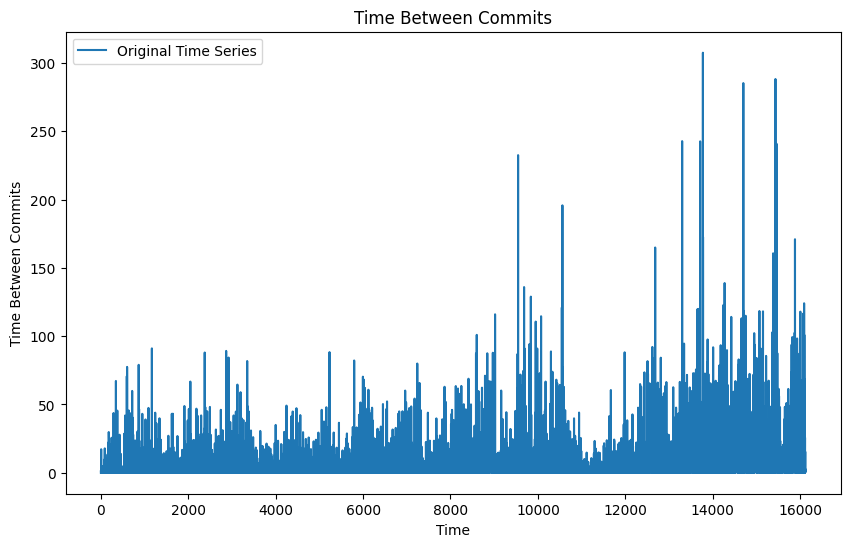

In [62]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(repo['time_between_commits'], label='Original Time Series')
plt.title('Time Between Commits')
plt.xlabel('Time')
plt.ylabel('Time Between Commits')
plt.legend()
plt.show()


In [63]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(timeseries):
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

check_stationarity(repo['time_between_commits'])


Results of Dickey-Fuller Test:
Test Statistic                -1.312423e+01
p-value                        1.540808e-24
#Lags Used                     3.400000e+01
Number of Observations Used    1.608800e+04
Critical Value (1%)           -3.430757e+00
Critical Value (5%)           -2.861720e+00
Critical Value (10%)          -2.566866e+00
dtype: float64


#### Apply Differencing

In [64]:
repo['diff_time_between_commits'] = repo['time_between_commits'].diff().dropna()

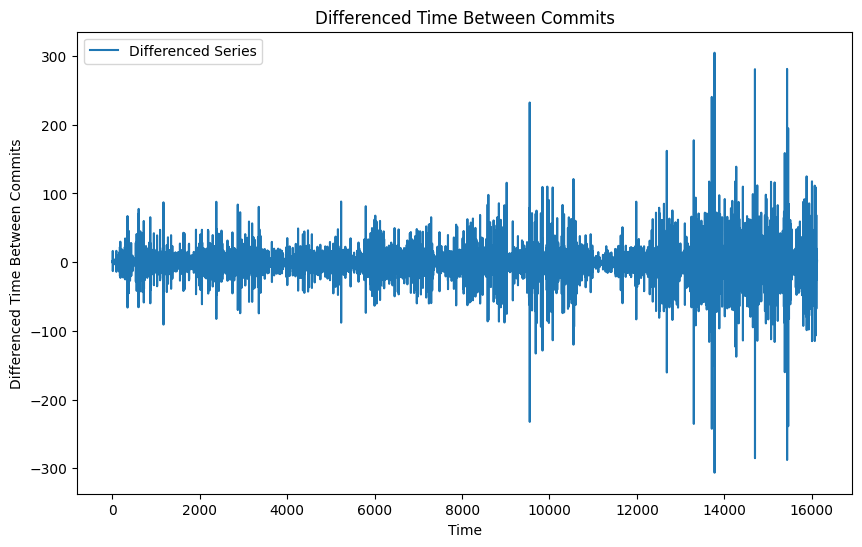

In [65]:
plt.figure(figsize=(10, 6))
plt.plot(repo['diff_time_between_commits'], label='Differenced Series')
plt.title('Differenced Time Between Commits')
plt.xlabel('Time')
plt.ylabel('Differenced Time Between Commits')
plt.legend()
plt.show()


#### Step 4: Fit the AR1 Model 

In [66]:
from statsmodels.tsa.ar_model import AutoReg

# Choose the right series based on the stationarity test
series_to_model = repo['diff_time_between_commits']

series_to_model = series_to_model.dropna()

model = AutoReg(series_to_model, lags=1)
model_fitted = model.fit()


C:\Users\ethan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [67]:
# Forecast the next value
forecast = model_fitted.predict(start=len(series_to_model), end=len(series_to_model))
print(forecast)


16122   -0.896446
dtype: float64


C:\Users\ethan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


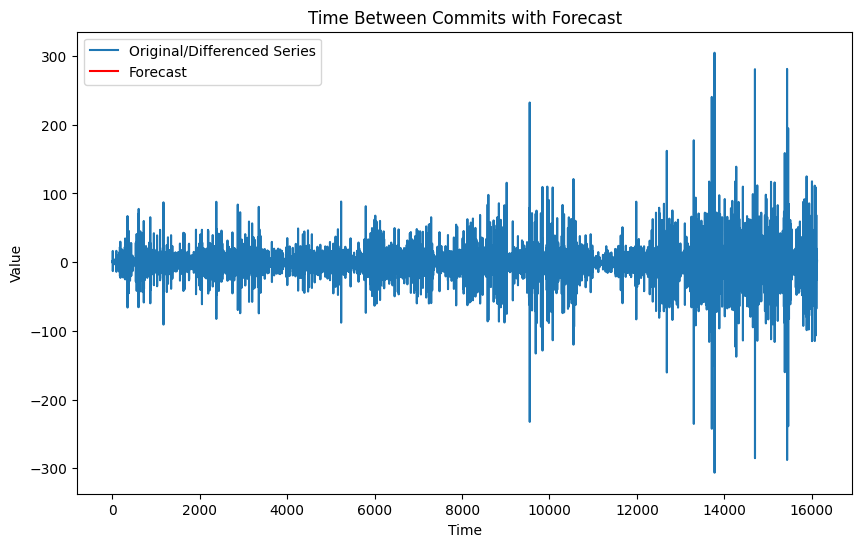

In [68]:
forecast_series = pd.Series(forecast, index=[len(series_to_model) + i for i in range(len(forecast))])

plt.figure(figsize=(10, 6))
plt.plot(series_to_model, label='Original/Differenced Series')
plt.plot(forecast_series, 'r', label='Forecast')
plt.title('Time Between Commits with Forecast')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()


In [69]:
print(model_fitted.summary())

residuals = model_fitted.resid
print('Residuals mean:', residuals.mean())


                                AutoReg Model Results                                
Dep. Variable:     diff_time_between_commits   No. Observations:                16122
Model:                            AutoReg(1)   Log Likelihood              -67016.277
Method:                      Conditional MLE   S.D. of innovations             15.458
Date:                       Tue, 13 Feb 2024   AIC                         134038.554
Time:                               13:34:40   BIC                         134061.618
Sample:                                    1   HQIC                        134046.179
                                       16122                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                         4.676e-05      0.122      0.000      1.000      -0.239       0.239
diff_time_between_com

#### stationary test and differenceing

In [71]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(repo['time_between_commits'])

# Extracting the test statistic and p-value
adf_statistic, p_value = adf_result[0], adf_result[1]

adf_statistic, p_value


(-13.124233220786788, 1.5408076570922842e-24)

In [72]:
df_diff = repo['time_between_commits'].diff().dropna()

# Conducting the ADF test again on the differenced data
adf_result_diff = adfuller(df_diff)

adf_statistic_diff, p_value_diff = adf_result_diff[0], adf_result_diff[1]

adf_statistic_diff, p_value_diff


(-31.59401907387769, 0.0)

C:\Users\ethan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ethan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ethan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. fore

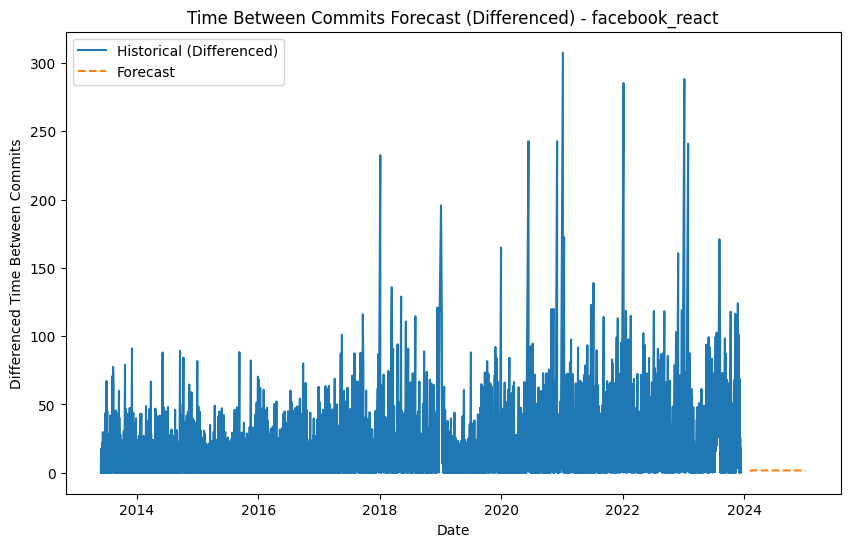

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict

df['date'] = pd.to_datetime(df['date'])

df.set_index('date', inplace=True)


model_diff = ARIMA(repo['time_between_commits'], order=(1, 1, 0))
model_fit_diff = model_diff.fit()

forecast_diff = model_fit_diff.forecast(steps=12)

last_date = repo.index[-1]

forecast_dates = pd.date_range(start=last_date, periods=len(forecast_diff)+1, freq='MS')[1:]

plt.figure(figsize=(10, 6))
plt.plot(repo.index, repo['time_between_commits'], label='Historical (Differenced)')
plt.plot(forecast_dates, forecast_diff, label='Forecast', linestyle='--')
plt.title('Time Between Commits Forecast (Differenced) - facebook_react')  
plt.xlabel('Date')
plt.ylabel('Differenced Time Between Commits')
plt.legend()
plt.show()


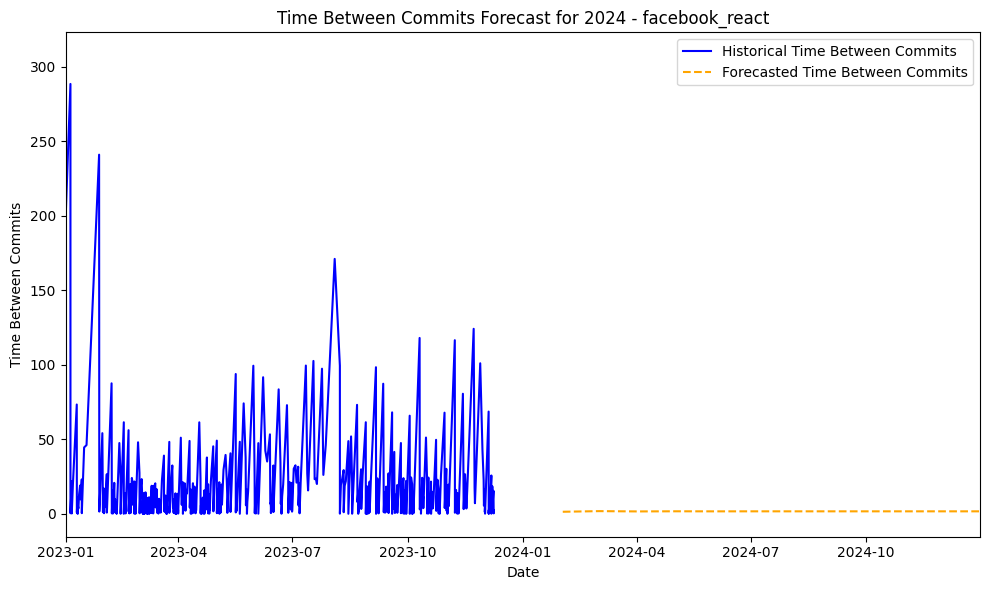

In [74]:
plt.figure(figsize=(10, 6))
# Historical data: using a solid blue line
plt.plot(repo.index, repo['time_between_commits'], label='Historical Time Between Commits', color='blue')
# Forecast data: using a dashed orange line
plt.plot(forecast_dates, forecast_diff, label='Forecasted Time Between Commits', color='orange', linestyle='--')

plt.title('Time Between Commits Forecast for 2024 - facebook_react')
plt.xlabel('Date')
plt.ylabel('Time Between Commits')
plt.legend()

plt.xlim(pd.Timestamp('2023-01-01'), pd.Timestamp('2024-12-31'))

plt.tight_layout()
plt.show()

In [75]:
forecast_diff

16123    1.365480
16124    1.786545
16125    1.588773
16126    1.681665
16127    1.638034
16128    1.658527
16129    1.648902
16130    1.653423
16131    1.651299
16132    1.652297
16133    1.651828
16134    1.652048
Name: predicted_mean, dtype: float64